In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import sys
sys.path.insert(0, os.getcwd()+"/../../../../libs/common")
from FileUtil import gpfs2WinPath

caldatafile = r'/gpfs/WW/BD/MXP/SHARED/SEM_IMAGE/IMEC/Case02_calaveras_v3/3Tmp/CT_KPI_test/Calaveras_v3_regular_CT_KPI_003_slope_modified_revert_all_patterns/h/cache/dummydb/result/MXP/job1/ContourSelectModelCalibration430result1/caldata.txt'
caldatafile = gpfs2WinPath(caldatafile)

df = pd.read_csv(caldatafile, sep='\s+')

tgtColName = 'UserLabel'
neighborColNames = ['NeighborOrientation', 'NeighborParalism']#, 'NeighborParalism', 'NeighborContinuity',
allColNames = ['NeighborContinuity', 'NeighborOrientation', 'NeighborParalism', 'slope', 'intensity', 'ridge_intensity', 'contrast', 'EigenRatio']
srcColNames = ['slope', 'intensity', 'ridge_intensity', 'NeighborOrientation', 'NeighborParalism']
tgtColName = 'UserLabel'

In [10]:
wiScaling = 1
scaling = lambda X_Arr: np.array([(X_Arr[i] - Xmin[i])/(Xmax[i] - Xmin[i]) for i in range(len(srcColNames)) ]).T
if wiScaling:
    X_cal = df.loc[df.usage=='CAL', srcColNames].values
    Xmin = X_cal.min(axis=0)
    Xmax = X_cal.max(axis=0)
    print(Xmin, Xmax)
    df.loc[:, srcColNames] = df.loc[:, srcColNames].apply(scaling, axis=1)

X_cal = df.loc[df.usage=='CAL', srcColNames].values
y_cal = df.loc[df.usage=='CAL', tgtColName].values
X_ver = df.loc[df.usage=='VER', srcColNames].values
y_ver = df.loc[df.usage=='VER', tgtColName].values

[-1.93929672e-03  3.45613688e-01  8.14414874e-04  9.34455174e-01
  6.81708408e-01] [0.00160159 0.60827112 0.02619517 1.         1.        ]


In [11]:
df.loc[:, srcColNames].describe()

,slope,intensity,ridge_intensity,NeighborOrientation,NeighborParalism
count,3308.000000,3308.000000,3308.000000,3308.000000,3308.000000
mean,0.672737,0.548713,0.477082,0.981229,0.988088
std,0.103347,0.235707,0.228646,0.056191,0.063183
min,0.000000,-0.007341,0.000000,0.000000,0.000000
25%,0.609228,0.380234,0.329494,0.985239,0.998756
50%,0.675926,0.532438,0.498684,0.997393,0.999837
75%,0.741071,0.750798,0.659993,0.999549,0.999975
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
%matplotlib auto

# hist plot 

df2 = pd.melt(df, id_vars=tgtColName, value_vars=neighborColNames, value_name='value')
bins=np.linspace(df2.value.min(), df2.value.max(), 100)
g = sns.FacetGrid(df2, col="variable", hue=tgtColName, palette="Set1", col_wrap=3)
g.map(plt.hist, 'value', bins=bins, ec="k")
plt.yscale('log')
g.axes[-1].legend()

# scatter plot 
#sns.pointplot('NeighborOrientation', 'NeighborParalism', hue=tgtColName, data=df)

plt.show()

In [21]:
%matplotlib auto
def sephist(col):
    TP = df[df[tgtColName] == 0][col]
    TN = df[df[tgtColName] == 1][col]
    return TP, TN
#df.loc[:, 'slope'] = df.loc[:, 'slope'].abs()
for num, alpha in enumerate(allColNames):
    plt.subplot(2, 4, num+1)

    TP, TN = sephist(alpha)
    plt.hist((TP, TN), bins=25, alpha=0.5, label=map(''.join, zip(2*[tgtColName], 2*['=='], ['0', '1'])), color=['b', 'g'])
    #plt.hist(TP, bins=50, alpha=0.5, label=tgtColName+'==0', color='b')
    #plt.hist(TN, bins=50, alpha=0.5, label=tgtColName+'==1', color='g')
    plt.legend(loc='upper right')
    plt.title(alpha)
    plt.yscale('log')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Using matplotlib backend: Qt5Agg


C:\Users\peyang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [ ]:
df.loc[:, tgtColName].value_counts()

In [ ]:
df.loc[df[tgtColName]==0, srcColNames].describe()

In [ ]:
df.loc[df[tgtColName]==1, srcColNames].describe()

In [22]:
from sklearn import svm
clf = svm.SVC(kernel='linear', class_weight='balanced') # {0: 10, 1: 1}
model = clf.fit(X_cal, y_cal)

modelform = pd.DataFrame(data=clf.coef_.flatten(), index=srcColNames)
modelform.loc['intercept', 0] = clf.intercept_
print(modelform)

                             0
slope                 2.449888
intensity            -0.258894
ridge_intensity      10.758738
NeighborOrientation  -0.275622
NeighborParalism      1.521105
intercept            -5.122774


AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [26]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0) # , max_depth=len(srcColNames)+1, min_samples_split=3
model = clf.fit(X_cal, y_cal)
feature_importance = pd.DataFrame(data=model.feature_importances_.flatten(), index=srcColNames)
print(feature_importance)

#print(model.decision_path(X_cal))
print(model.get_params())

                            0
slope                0.041228
intensity            0.022051
ridge_intensity      0.900993
NeighborOrientation  0.024499
NeighborParalism     0.011229
{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}


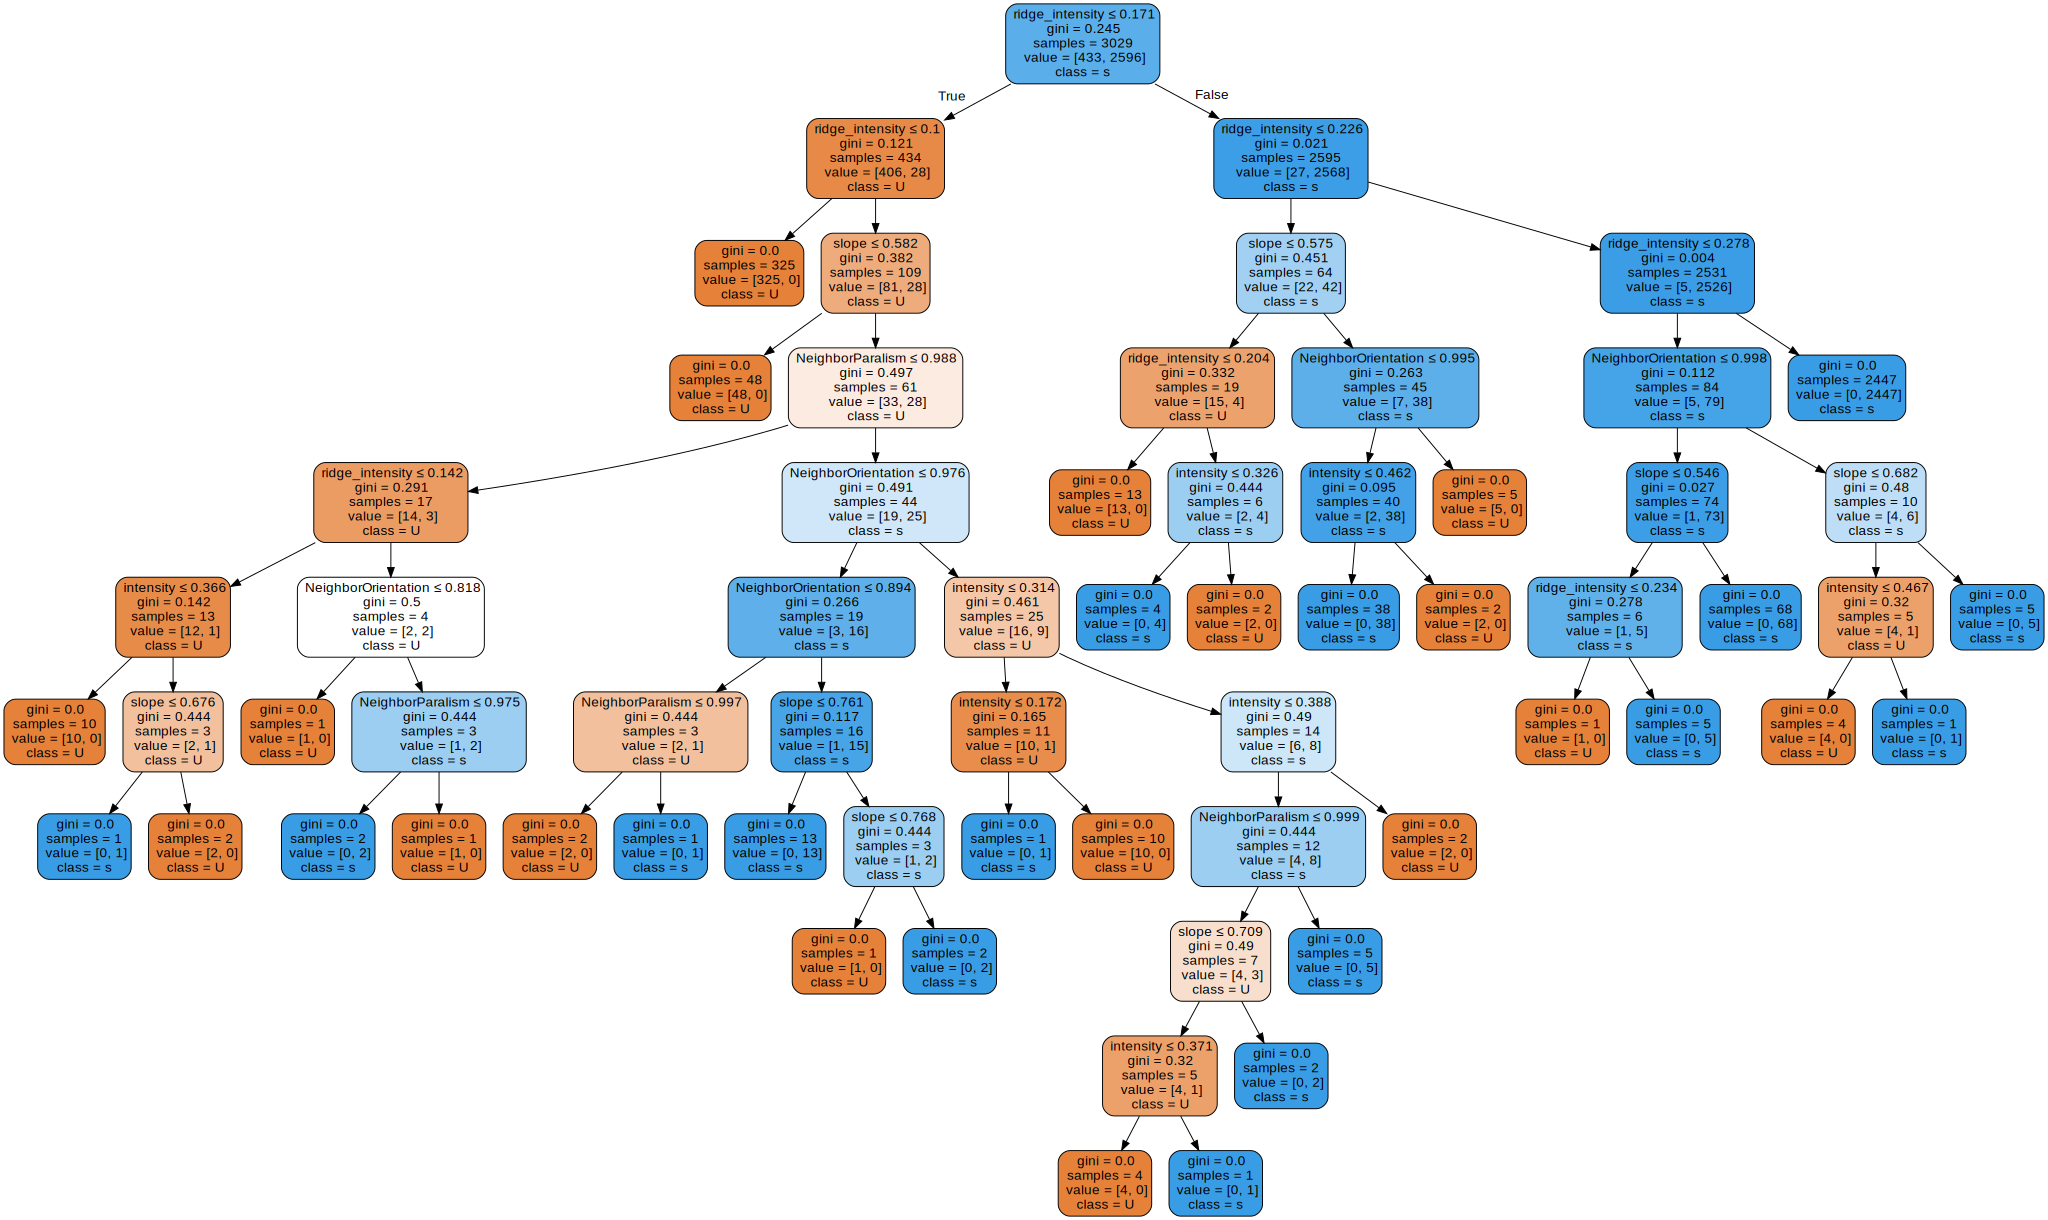

In [19]:
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=srcColNames,  
                         class_names=tgtColName,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)  
graph

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=0)
model = clf.fit(X_cal, y_cal)
feature_importance = pd.DataFrame(data=model.feature_importances_.flatten(), index=srcColNames)
print(feature_importance)

                            0
slope                0.068835
intensity            0.315280
ridge_intensity      0.481612
NeighborOrientation  0.016318
NeighborParalism     0.117955


In [17]:
from sklearn.metrics import confusion_matrix
calcRMS = lambda y_pred, y: np.sqrt(np.mean(np.power(y_pred - y, 2)))
def predict(X, y, usage='CAL'):
    y_pred = model.predict(X)
    rms = calcRMS(y_pred, y)
    cm = confusion_matrix(y, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Clf model rms on {} set: {}".format(usage, rms))
    print("Clf model confusion matrix on {} set:\n{}\n{}".format(usage, cm, cm_norm))
predict(X_cal, y_cal)
predict(X_ver, y_ver, 'VER')

Clf model rms on CAL set: 0.0602624391430992
Clf model confusion matrix on CAL set:
[[ 425    8]
 [   3 2593]]
[[0.98152425 0.01847575]
 [0.00115562 0.99884438]]
Clf model rms on VER set: 0.2932942300427066
Clf model confusion matrix on VER set:
[[  9   0]
 [ 24 246]]
[[1.         0.        ]
 [0.08888889 0.91111111]]


In [14]:
%matplotlib auto
import sys
import os.path
sys.path.insert(0, os.getcwd()+"/../../../../libs/tacx")
print(os.getcwd()+"/../../../../libs/tacx")
from SEMContour import *
sys.path.insert(0, os.getcwd()+"/../../../../libs/common")
from FileUtil import gpfs2WinPath

import glob

CWD = ''.join(['/gpfs/WW/BD/MXP/SHARED/SEM_IMAGE/IMEC/Case02_calaveras_v3/3Tmp/CT_KPI_test/Calaveras_v3_regular_CT_KPI_003_slope_modified_revert_all_patterns/'
      'h/cache/dummydb/result/MXP/job1/ContourSelectModelCalibration430result1'])

''' # comment block 1 starts
#################
# type 1, review model apply image by random permutation
#################
pathfilter = '*_image_contour.txt'
pathex = gpfs2WinPath(os.path.join(CWD, pathfilter))
contourfiles = glob.glob(pathex)
contourindice = np.random.permutation(np.arange(len(contourfiles)))
for ii in range(0*8, 1*8):
    fig = plt.figure()
    for jj, idx in enumerate(contourindice[ii*8:(ii+1)*8]):
        contourfile = contourfiles[idx]
        patternid = os.path.basename(contourfile).strip('_image_contour.txt')
        ################# end of type 1
''' # comment block 1 ends
        
#################
# type 2, review model apply image by giving list
#################
patternids = [461, 1001]

for ii in range(int(np.ceil(len(patternids)/8.))):
    fig = plt.figure()
    for jj, idx in enumerate(range(ii*8, (ii+1)*8)):
        patternid = str(patternids[idx])
        contourfile = gpfs2WinPath(os.path.join(CWD, patternid+'_image_contour.txt'))
        ################# end of type 2        
        
        
        if not os.path.exists(contourfile):
            print(patternid+' not exist')
            continue

        class ContourAnalyzer(object):
            """docstring for ContourData"""
            def __init__(self, contourfile):
                self.__build(contourfile)

            def __build(self, contourfile):
                contour = SEMContour()
                contour.parseFile(contourfile)
                if not contour:
                    sys.exit("ERROR: read in contour file %s fails\n" % contourfile)
                self.contour = contour
                self.df = contour.toDf()
        # get contour data
        ca = ContourAnalyzer(contourfile)
        contour = ca.contour
        df = ca.df


        X_test = df.loc[:, srcColNames].values
        X_test = np.array([(X_test[:,i] - Xmin[i])/(Xmax[i] - Xmin[i]) for i in range(len(srcColNames)) ]).T
        df.loc[:, 'ClfLabel'] = model.predict(X_test)
        # SEM Contour Selection resulst plot: by classifer Positive 0, & Negative 1
        def plotContourDiscriminator(contour, im=None, wndname=''):
            # plot image and classified contour point
            
            ax = fig.add_subplot(2,4,jj+1)

            imw, imh = contour.getshape()
            ax.set_aspect('equal')
            '''
            ax.set_xlim([0, imw])
            ax.set_ylim([0, imh])
            '''
            xini, yini, xend, yend = contour.getBBox()
            ax.set_xlim([xini, xend])
            ax.set_ylim([yini, yend])
            ax.set_title(wndname)

            df = contour.toDf()
            Positive = df.ClfLabel==0
            Negative = df.ClfLabel==1

            # calculate confusion matrix
            cm = np.array([len(df.loc[flt, :]) for flt in [Positive, Negative]])
            cm_norm = cm.astype('float') / cm.sum()

            if im is not None:
                ax.imshow(im)
            ax.plot(df.loc[Positive ,'offsetx'], df.loc[Positive, 'offsety'], #'b.', markersize=1, 
                    linestyle='None', marker= 'o', markeredgecolor='r', markersize=2, markeredgewidth=1, markerfacecolor='none', 
                    label='remove: {}({:.3f}%)'.format(cm[0], cm_norm[0]*100 )) #Discriminator Positive, ClfLabel=0
            ax.plot(df.loc[Negative ,'offsetx'], df.loc[Negative, 'offsety'], #'r*', markersize=2,
                    linestyle='None', marker= '.', markeredgecolor='b', markersize=2, markeredgewidth=1, markerfacecolor='none', 
                    label='Keep: {}({:.3f}%)'.format(cm[1], cm_norm[1]*100 )) #Discriminator Negative, ClfLabel=1:

            #ax = plt.gca() # gca() function returns the current Axes instance
            #ax.set_ylim(ax.get_ylim()[::-1]) # reverse Y
            plt.gca().invert_yaxis()
            plt.legend(loc=1)
            plt.show()
        plotContourDiscriminator(contour.fromDf(df), wndname='Pattern '+ patternid)

Using matplotlib backend: Qt5Agg
C:\Localdata\D\Note\Python\apps\MXP\ContourSelect\unittest/../../../../libs/tacx
349 not exist
713 not exist
849 not exist
551 not exist
704 not exist
175 not exist
187 not exist
122 not exist
192 not exist
426 not exist
3746 not exist
1169 not exist
3742 not exist
1593 not exist
347 not exist
3133 not exist
1841 not exist
